In [231]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')


from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings("ignore")




In [232]:
# Identify the first 1000 unique LCLid values
# df=pd.read_csv("CC_LCL-FullData.csv")

In [233]:
# Identify the first 1000 unique LCLid values
# Identify the first 1000 unique LCLid values
# unique_ids = df['LCLid'].unique()[:1000]

# Filter the DataFrame to include only rows with those 500 unique LCLid values
# Identify the first 1000 unique LCLid values

# df_1000 = df[df['LCLid'].isin(unique_ids)]

# Display the first few rows of the new DataFrame
#print(df_500.head())

In [234]:
# df_1000.to_csv("energy_data_1000.csv")

# loading energy dataset

In [236]:
df=pd.read_csv("energy_data_1000.csv")
df.head()

,Unnamed: 0,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,0,MAC000002,Std,2012-10-12 00:30:00.0000000,0
1,1,MAC000002,Std,2012-10-12 01:00:00.0000000,0
2,2,MAC000002,Std,2012-10-12 01:30:00.0000000,0
3,3,MAC000002,Std,2012-10-12 02:00:00.0000000,0
4,4,MAC000002,Std,2012-10-12 02:30:00.0000000,0


In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32692099 entries, 0 to 32692098
Data columns (total 5 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   Unnamed: 0               int64 
 1   LCLid                    object
 2   stdorToU                 object
 3   DateTime                 object
 4   KWH/hh (per half hour)   object
dtypes: int64(1), object(4)
memory usage: 1.2+ GB


# data cleaning

# Convert DateTime column to datetime format

In [240]:
# Convert DateTime column to datetime format
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract date only and remove time
df['DateTime'] = df['DateTime'].dt.date

# replacing string NULLL with nan

In [242]:
df['KWH/hh (per half hour) '] = df['KWH/hh (per half hour) '].replace('Null', np.nan)
df=df.dropna(axis=0)
df['KWH/hh (per half hour) ']=df['KWH/hh (per half hour) '].astype(float)

# calculating total energy consumption per month and dropping energy consumption per hour 

In [244]:

# Create a column for year and week
df['YearWeek'] = df['DateTime'].apply(lambda x: x.strftime('%Y-%U'))

# Calculate weekly energy consumption for each LCLid
weekly_consumption = df.groupby(['LCLid', 'YearWeek'])['KWH/hh (per half hour) '].sum().reset_index()
weekly_consumption.rename(columns={'KWH/hh (per half hour) ': 'WeeklyConsumption'}, inplace=True)

# Add start and end date columns
weekly_consumption['StartDate'] = weekly_consumption['YearWeek'].apply(lambda x: pd.to_datetime(x + '-0', format='%Y-%U-%w'))
weekly_consumption['EndDate'] = weekly_consumption['StartDate'] + pd.offsets.Week(weekday=6)

# Drop the YearWeek column as it's no longer needed
weekly_consumption = weekly_consumption.drop(columns=['YearWeek'])

# Display the result
weekly_consumption.head()



,LCLid,WeeklyConsumption,StartDate,EndDate
0,MAC000002,18.185,2012-10-07,2012-10-14
1,MAC000002,80.894,2012-10-14,2012-10-21
2,MAC000002,114.476,2012-10-21,2012-10-28
3,MAC000002,105.301,2012-10-28,2012-11-04
4,MAC000002,84.555,2012-11-04,2012-11-11


# creating new features from date time

In [246]:
# Ensure StartDate and EndDate are in datetime format
weekly_consumption['StartDate'] = pd.to_datetime(weekly_consumption['StartDate'])
weekly_consumption['EndDate'] = pd.to_datetime(weekly_consumption['EndDate'])

# Extract year, month, quarter, start day, end day, and week
weekly_consumption['year'] = weekly_consumption['StartDate'].dt.year
weekly_consumption['month'] = weekly_consumption['StartDate'].dt.month
weekly_consumption['quarter'] = weekly_consumption['StartDate'].dt.quarter
weekly_consumption['start_day'] = weekly_consumption['StartDate'].dt.day
weekly_consumption['end_day'] = weekly_consumption['EndDate'].dt.day
weekly_consumption['week'] = weekly_consumption['StartDate'].dt.isocalendar().week


In [247]:
weekly_consumption.head()

,LCLid,WeeklyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,week
0,MAC000002,18.185,2012-10-07,2012-10-14,2012,10,4,7,14,40
1,MAC000002,80.894,2012-10-14,2012-10-21,2012,10,4,14,21,41
2,MAC000002,114.476,2012-10-21,2012-10-28,2012,10,4,21,28,42
3,MAC000002,105.301,2012-10-28,2012-11-04,2012,10,4,28,4,43
4,MAC000002,84.555,2012-11-04,2012-11-11,2012,11,4,4,11,44


# loading informations_households dataset

In [249]:
household_info=pd.read_csv("informations_households.csv")

In [250]:
household_info.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [251]:
# Rename columns
household_info.rename(columns={
    'Acorn_grouped': 'AcornGroup'}, inplace=True)

In [252]:
weekly_consumption

,LCLid,WeeklyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,week
0,MAC000002,18.185,2012-10-07,2012-10-14,2012,10,4,7,14,40
1,MAC000002,80.894,2012-10-14,2012-10-21,2012,10,4,14,21,41
2,MAC000002,114.476,2012-10-21,2012-10-28,2012,10,4,21,28,42
3,MAC000002,105.301,2012-10-28,2012-11-04,2012,10,4,28,4,43
4,MAC000002,84.555,2012-11-04,2012-11-11,2012,11,4,4,11,44
...,...,...,...,...,...,...,...,...,...,...
100273,MAC001250,139.234,2014-01-12,2014-01-19,2014,1,1,12,19,2
100274,MAC001250,139.775,2014-01-19,2014-01-26,2014,1,1,19,26,3
100275,MAC001250,134.883,2014-01-26,2014-02-02,2014,1,1,26,2,4
100276,MAC001250,105.038,2014-02-02,2014-02-09,2014,2,1,2,9,5


# merge energy consumption dataset with households dataset

In [254]:
df_final=weekly_consumption.merge(household_info,on='LCLid',how='left')


In [255]:
df_final=df_final[['LCLid', 'WeeklyConsumption', 'StartDate', 'EndDate', 'year', 'month',
       'quarter', 'start_day', 'end_day','week', 'AcornGroup']]
df_final.head()

,LCLid,WeeklyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,week,AcornGroup
0,MAC000002,18.185,2012-10-07,2012-10-14,2012,10,4,7,14,40,Affluent
1,MAC000002,80.894,2012-10-14,2012-10-21,2012,10,4,14,21,41,Affluent
2,MAC000002,114.476,2012-10-21,2012-10-28,2012,10,4,21,28,42,Affluent
3,MAC000002,105.301,2012-10-28,2012-11-04,2012,10,4,28,4,43,Affluent
4,MAC000002,84.555,2012-11-04,2012-11-11,2012,11,4,4,11,44,Affluent


# exploratory data analysis

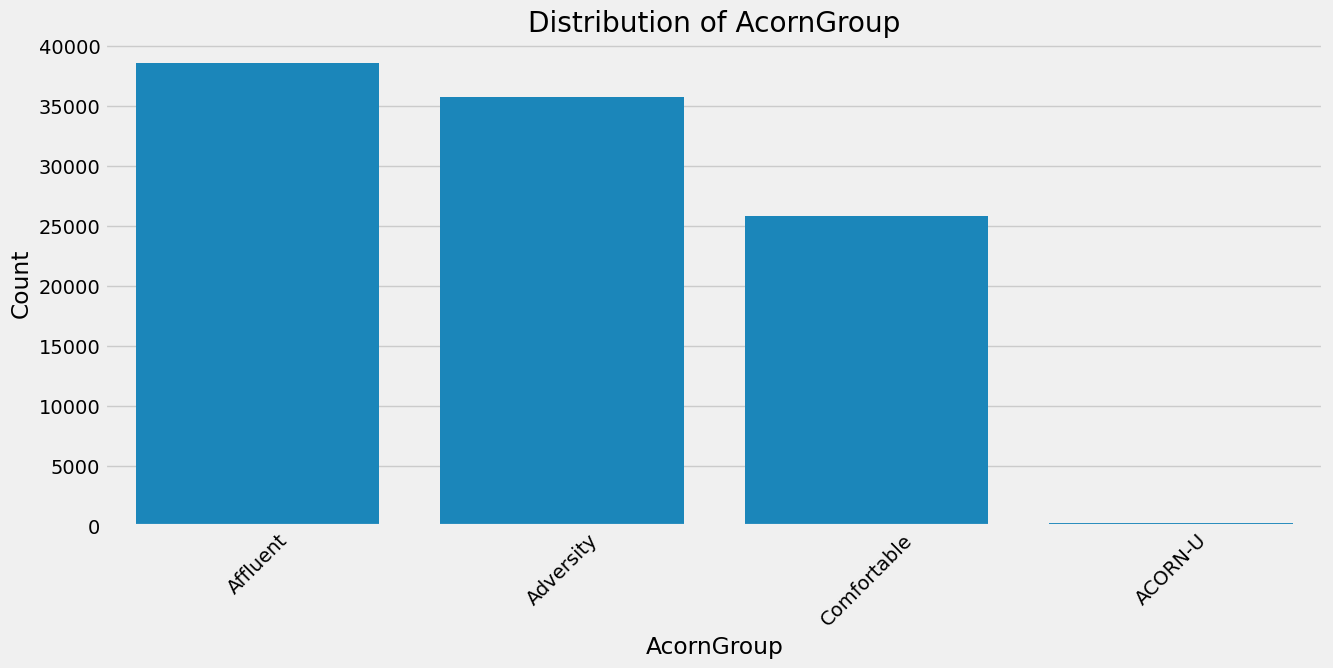

In [257]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_final, x='AcornGroup', order=df_final['AcornGroup'].value_counts().index)
plt.title('Distribution of AcornGroup')
plt.xlabel('AcornGroup')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

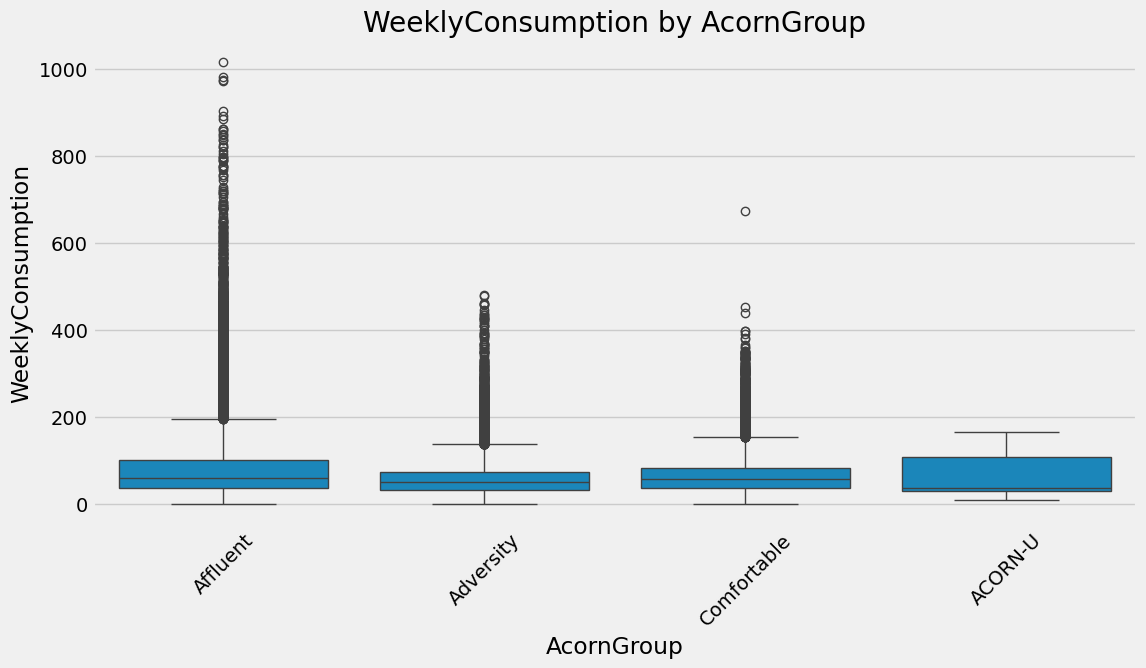

In [258]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_final, x='AcornGroup', y='WeeklyConsumption')
plt.title('WeeklyConsumption by AcornGroup')
plt.xlabel('AcornGroup')
plt.ylabel('WeeklyConsumption')
plt.xticks(rotation=45)
plt.show()

In [259]:


# Calculate descriptive statistics
grouped_stats = df_final.groupby('AcornGroup')['WeeklyConsumption'].agg(['mean', 'median', 'std','min','max', 'count']).reset_index()

# Print the table
print(grouped_stats)


    AcornGroup       mean   median        std    min          max  count
0      ACORN-U  64.219089  36.1540  41.579644  7.274   163.895000    237
1    Adversity  57.905563  48.6795  40.823686  0.000   479.636000  35700
2     Affluent  80.913676  59.2820  76.851499  0.000  1017.029999  38566
3  Comfortable  65.608909  56.4340  43.994242  0.000   672.585000  25775


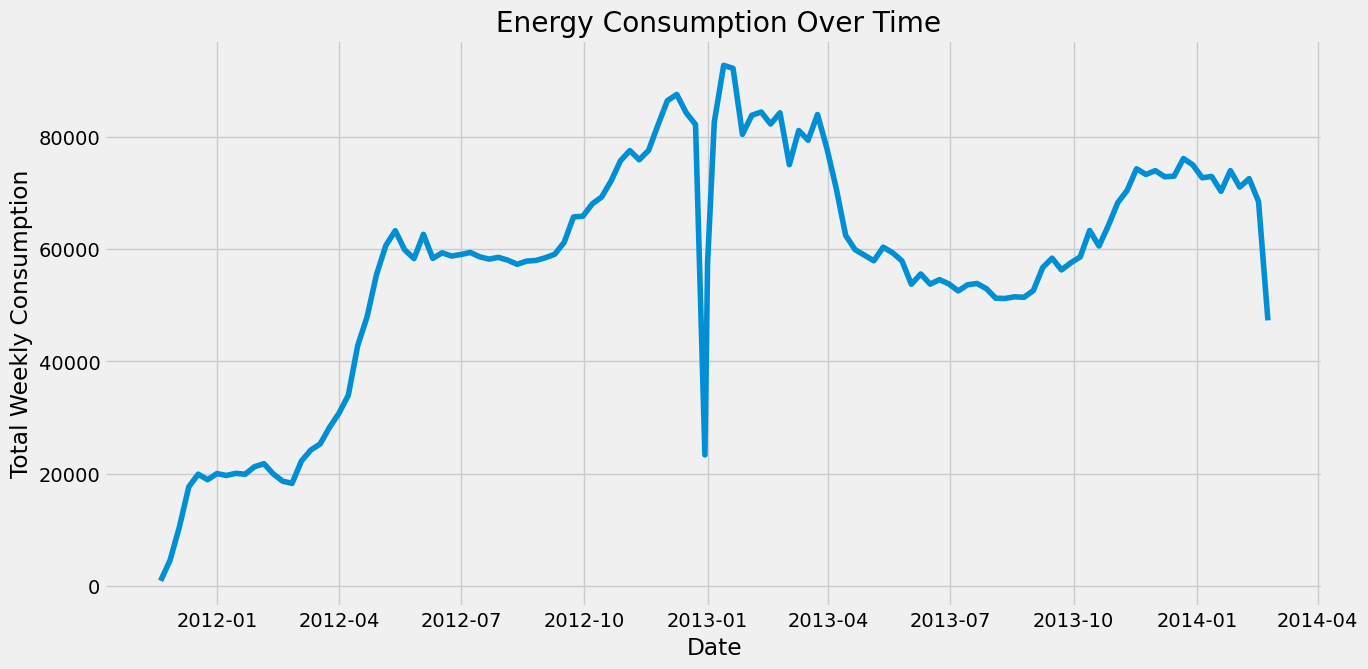

In [260]:
Weekly_Consumption = df_final.groupby('StartDate')['WeeklyConsumption'].sum().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(Weekly_Consumption['StartDate'], Weekly_Consumption['WeeklyConsumption'])
plt.title(' Energy Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Total Weekly Consumption')
plt.show()

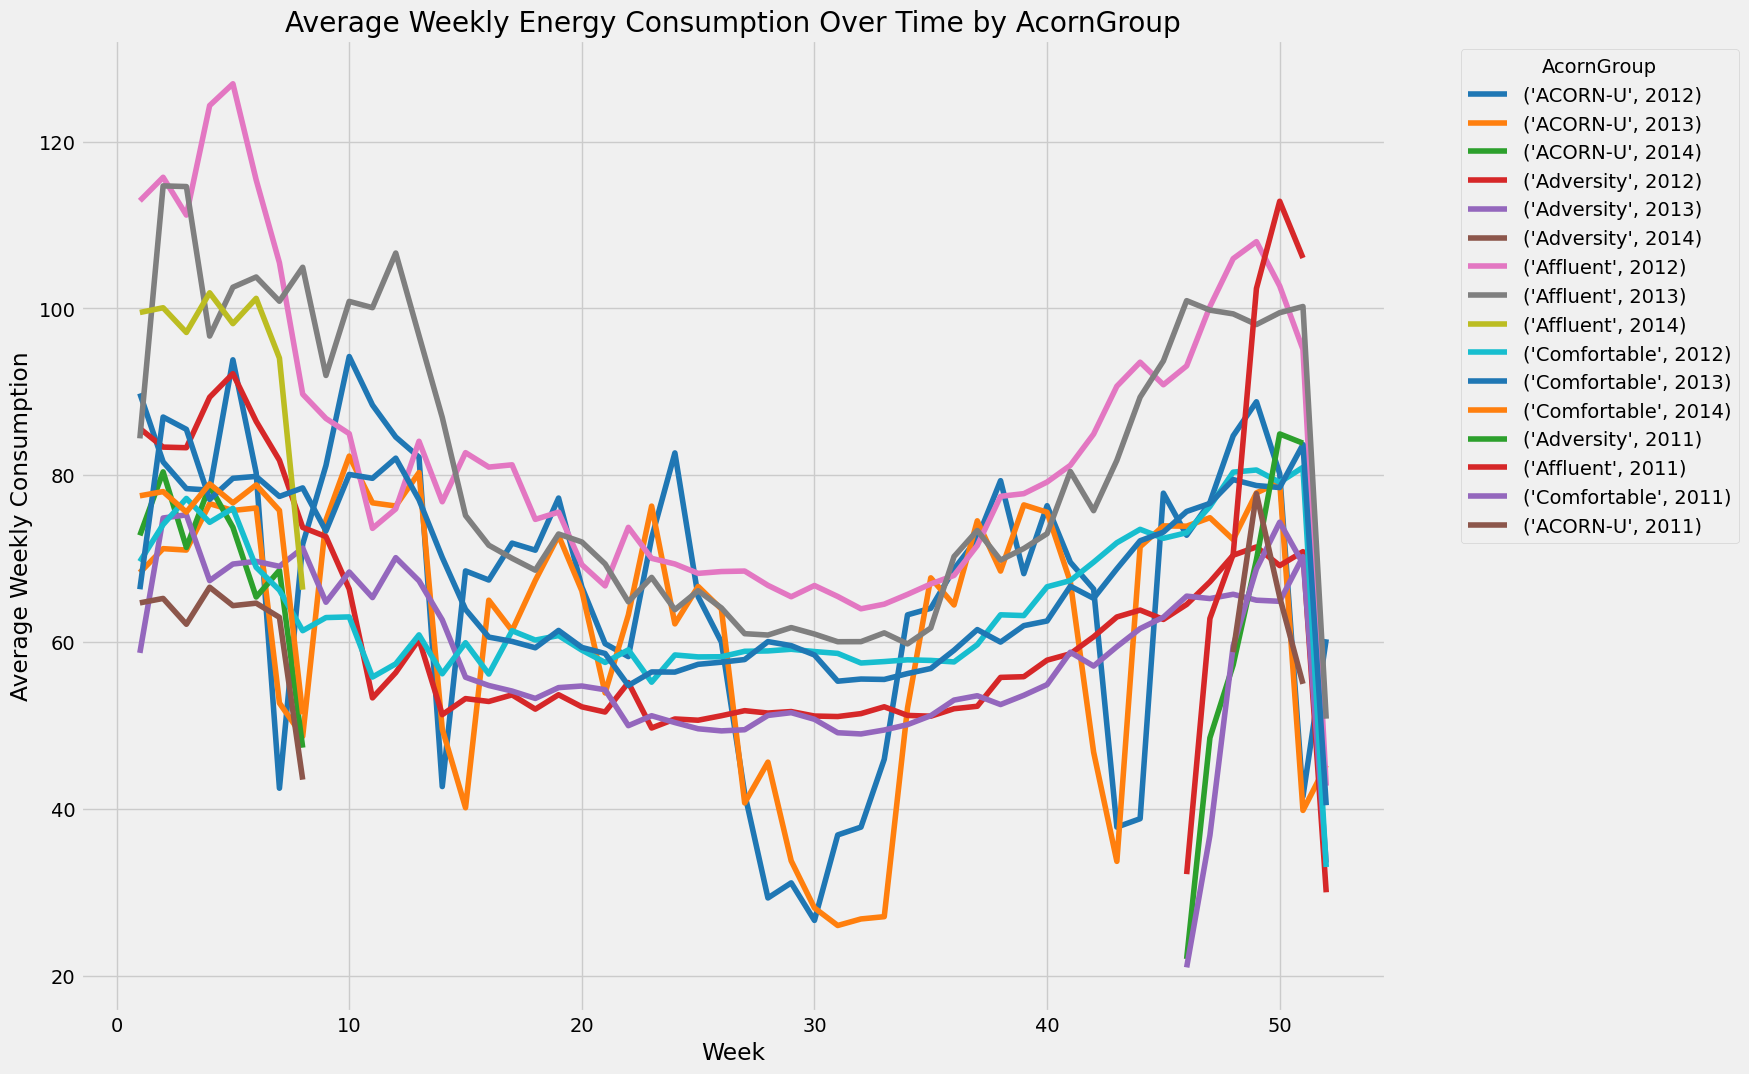

In [261]:

# Aggregate data by date and AcornGroup
grouped_data = df_final.groupby(['week', 'AcornGroup','year'])['WeeklyConsumption'].mean().reset_index()

# Pivot the data to have StartDate as index and AcornGroup as columns
pivot_data = grouped_data.pivot(index='week', columns=['AcornGroup','year'], values='WeeklyConsumption')

# Plotting
plt.figure(figsize=(15, 12))

# Choose a color palette
palette = sns.color_palette("tab10", len(pivot_data.columns))

# Plot each AcornGroup with a different color
for i, group in enumerate(pivot_data.columns):
    plt.plot(pivot_data.index, pivot_data[group], label=group, color=palette[i])

plt.title('Average Weekly Energy Consumption Over Time by AcornGroup')
plt.xlabel('Week')
plt.ylabel('Average Weekly Consumption')

# Adjust the legend
plt.legend(title='AcornGroup', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


       WeeklyConsumption                      StartDate  \
count         119.000000                            119   
mean           46.213924  2013-01-15 20:10:05.042016768   
min            14.634000            2011-12-04 00:00:00   
25%            28.703500            2012-06-27 12:00:00   
50%            56.398000            2013-01-13 00:00:00   
75%            62.481500            2013-08-07 12:00:00   
max            70.038000            2014-02-23 00:00:00   
std            18.872837                            NaN   

                             EndDate         year       month     quarter  \
count                            119   119.000000  119.000000  119.000000   
mean   2013-01-22 19:45:52.941176576  2012.554622    6.386555    2.453782   
min              2011-12-11 00:00:00  2011.000000    1.000000    1.000000   
25%              2012-07-04 12:00:00  2012.000000    3.000000    1.000000   
50%              2013-01-20 00:00:00  2013.000000    6.000000    2.000000   
75%   

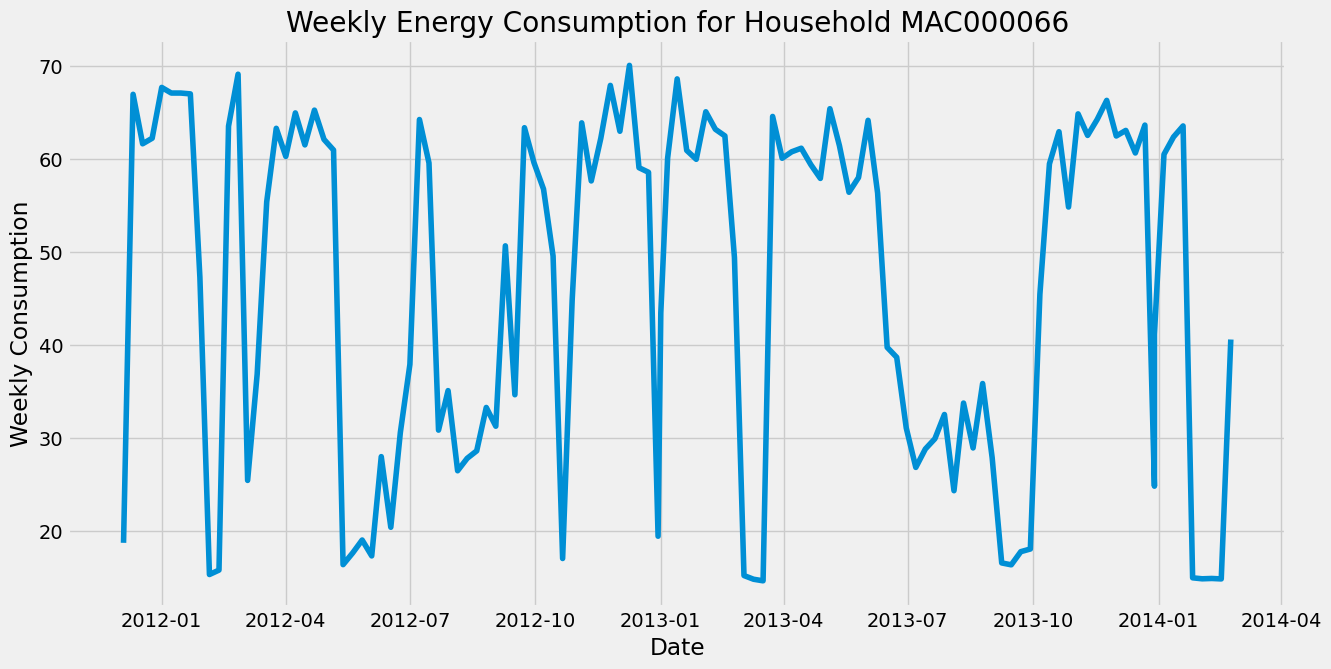

In [262]:
household_id = 'MAC000066'
household_data = df_final[df_final['LCLid'] == household_id]

# Basic statistics for the household
print(household_data.describe())

# Time series plot for the household
plt.figure(figsize=(14, 7))
plt.plot(household_data['StartDate'], household_data['WeeklyConsumption'])
plt.title(f'Weekly Energy Consumption for Household {household_id}')
plt.xlabel('Date')
plt.ylabel('Weekly Consumption')
plt.show()

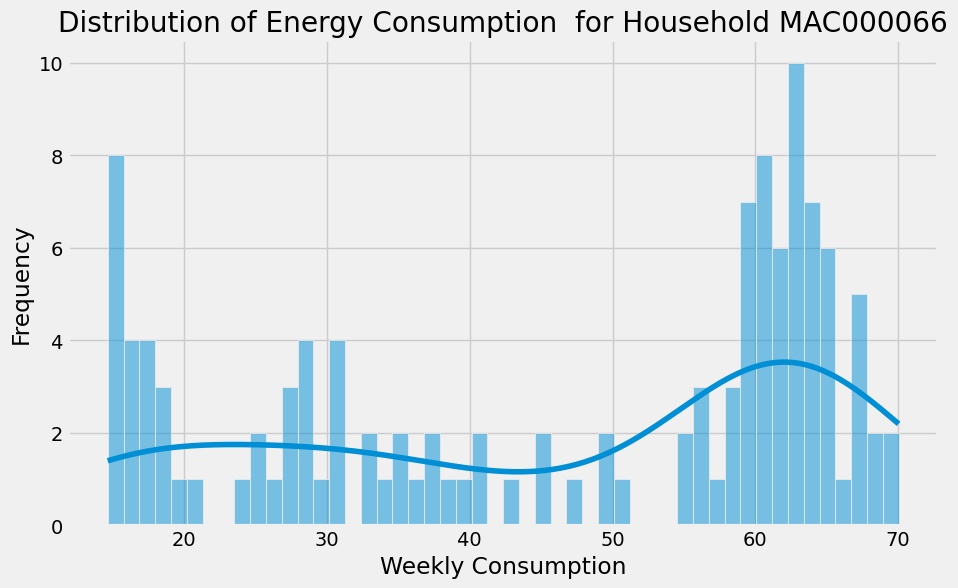

In [263]:
# Distribution of KW_per_day
plt.figure(figsize=(10, 6))
sns.histplot(household_data['WeeklyConsumption'], bins=50, kde=True)
plt.title('Distribution of Energy Consumption  for Household MAC000066')
plt.xlabel('Weekly Consumption')
plt.ylabel('Frequency')
plt.show()


# feature engineering: 
Create the new feature for previous month's energy consumption for each household


In [265]:
# Sort the dataframe by LCLid and StartDate to ensure the shift operation is correct
df_final = df_final.sort_values(by=['LCLid', 'StartDate'])

# Create the new feature for previous month's energy consumption
df_final['PrevweekConsumption'] = df_final.groupby('LCLid')['WeeklyConsumption'].shift(1)
df_final['PrevweekConsumption'].fillna(0, inplace=True)
df_final.head()

,LCLid,WeeklyConsumption,StartDate,EndDate,year,month,quarter,start_day,end_day,week,AcornGroup,PrevweekConsumption
0,MAC000002,18.185,2012-10-07,2012-10-14,2012,10,4,7,14,40,Affluent,0.000
1,MAC000002,80.894,2012-10-14,2012-10-21,2012,10,4,14,21,41,Affluent,18.185
2,MAC000002,114.476,2012-10-21,2012-10-28,2012,10,4,21,28,42,Affluent,80.894
3,MAC000002,105.301,2012-10-28,2012-11-04,2012,10,4,28,4,43,Affluent,114.476
4,MAC000002,84.555,2012-11-04,2012-11-11,2012,11,4,4,11,44,Affluent,105.301


# data preprocessing

In [267]:
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit the encoder to the 'original_language' column and transform it
df_final['AcornGroup'] = label_encoder.fit_transform(df_final['AcornGroup'])
print(df_final.head())

       LCLid  WeeklyConsumption  StartDate    EndDate  year  month  quarter  \
0  MAC000002             18.185 2012-10-07 2012-10-14  2012     10        4   
1  MAC000002             80.894 2012-10-14 2012-10-21  2012     10        4   
2  MAC000002            114.476 2012-10-21 2012-10-28  2012     10        4   
3  MAC000002            105.301 2012-10-28 2012-11-04  2012     10        4   
4  MAC000002             84.555 2012-11-04 2012-11-11  2012     11        4   

   start_day  end_day  week  AcornGroup  PrevweekConsumption  
0          7       14    40           2                0.000  
1         14       21    41           2               18.185  
2         21       28    42           2               80.894  
3         28        4    43           2              114.476  
4          4       11    44           2              105.301  


In [268]:
# Splitting data into X and y
X = df_final.drop(["LCLid",'StartDate','EndDate','WeeklyConsumption'], axis=1)
y = df_final["WeeklyConsumption"]


In [269]:
X.columns=X.columns.astype(str)

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [271]:

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data
X_train = scaler.fit_transform(X_train)

# Transform the testing data
X_test = scaler.transform(X_test)

# X_train_scaled and X_test_scaled are now standardized


In [272]:
def print_evaluate(true, predicted):
    # Mean Absolute Error
    mae = metrics.mean_absolute_error(true, predicted)
    # Mean Squarred Error
    mse = metrics.mean_squared_error(true, predicted)
    # Calculating R2 Score
    r2_score = metrics.r2_score(true, predicted)
    # Calculating RMSE Score
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))

    # Calculating mean_absolute_percentage_error
    mape = metrics.mean_absolute_percentage_error(true, predicted)

    print('Mean Absolute Error', mae)
    print('Mean Squarred Error', mse)
    print('Root Mean Squarred Error', rmse)
    print('mean_absolute_percentage_error', mape)
    print('R2 Score:', r2_score)

def evaluate(true, predicted):

    # Calculating MAE Score
    mae = metrics.mean_absolute_error(true, predicted)
    # Calculatinog MSE Score
    mse = metrics.mean_squared_error(true, predicted)
    # Calculationg R2 Score
    r2_score = metrics.r2_score(true, predicted)
    # Calculating RMSE Score
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))

    mape = metrics.mean_absolute_percentage_error(true, predicted)
    # Return ing Score
    return mae, mse, rmse,mape ,r2_score

# models with default parameters

In [274]:
def train_models(X_train, y_train, X_test, y_test):
    results_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2 Score'])

    # Models to be trained
    models = {
        
         'GradientBoostingRegressor': GradientBoostingRegressor(random_state=1000),
        'RandomForestRegressor': RandomForestRegressor(random_state=1000),
        'KNeighborsRegressor': KNeighborsRegressor(),
        
    }

    for i, (name, model) in enumerate(models.items()):
        print(f"Training and evaluating {name}...\n{'_'*40}")

        # Train the model
        model.fit(X_train, y_train)

        # Predictions
        test_pred = model.predict(X_test)
        train_pred = model.predict(X_train)

        # Evaluation
        print(f'Test set evaluation for {name}:\n{"_"*40}')
        print_evaluate(y_test, test_pred)
        print(f'Train set evaluation for {name}:\n{"_"*40}')
        print_evaluate(y_train, train_pred)
        results_df.loc[i] = [name, *evaluate(y_test, test_pred)]

    # Plot results
    print('====================================')
    print('Test set results for all models')
    plt.figure(figsize=(18, 18))
    for i, (name, model) in enumerate(models.items()):
        plt.subplot(3, 2, i + 1)
        plt.scatter(y_test, model.predict(X_test))
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(name)
    plt.show()

    return results_df

Training and evaluating GradientBoostingRegressor...
________________________________________
Test set evaluation for GradientBoostingRegressor:
________________________________________
Mean Absolute Error 10.353821148374038
Mean Squarred Error 396.7183518230309
Root Mean Squarred Error 19.91778983278594
mean_absolute_percentage_error 146391630735771.72
R2 Score: 0.8835317464569801
Train set evaluation for GradientBoostingRegressor:
________________________________________
Mean Absolute Error 10.127148576493532
Mean Squarred Error 354.31466451295836
Root Mean Squarred Error 18.823247979903957
mean_absolute_percentage_error 134111997874650.2
R2 Score: 0.8987033960568688
Training and evaluating RandomForestRegressor...
________________________________________
Test set evaluation for RandomForestRegressor:
________________________________________
Mean Absolute Error 11.305991986135341
Mean Squarred Error 439.80104399289974
Root Mean Squarred Error 20.971433999440755
mean_absolute_percenta

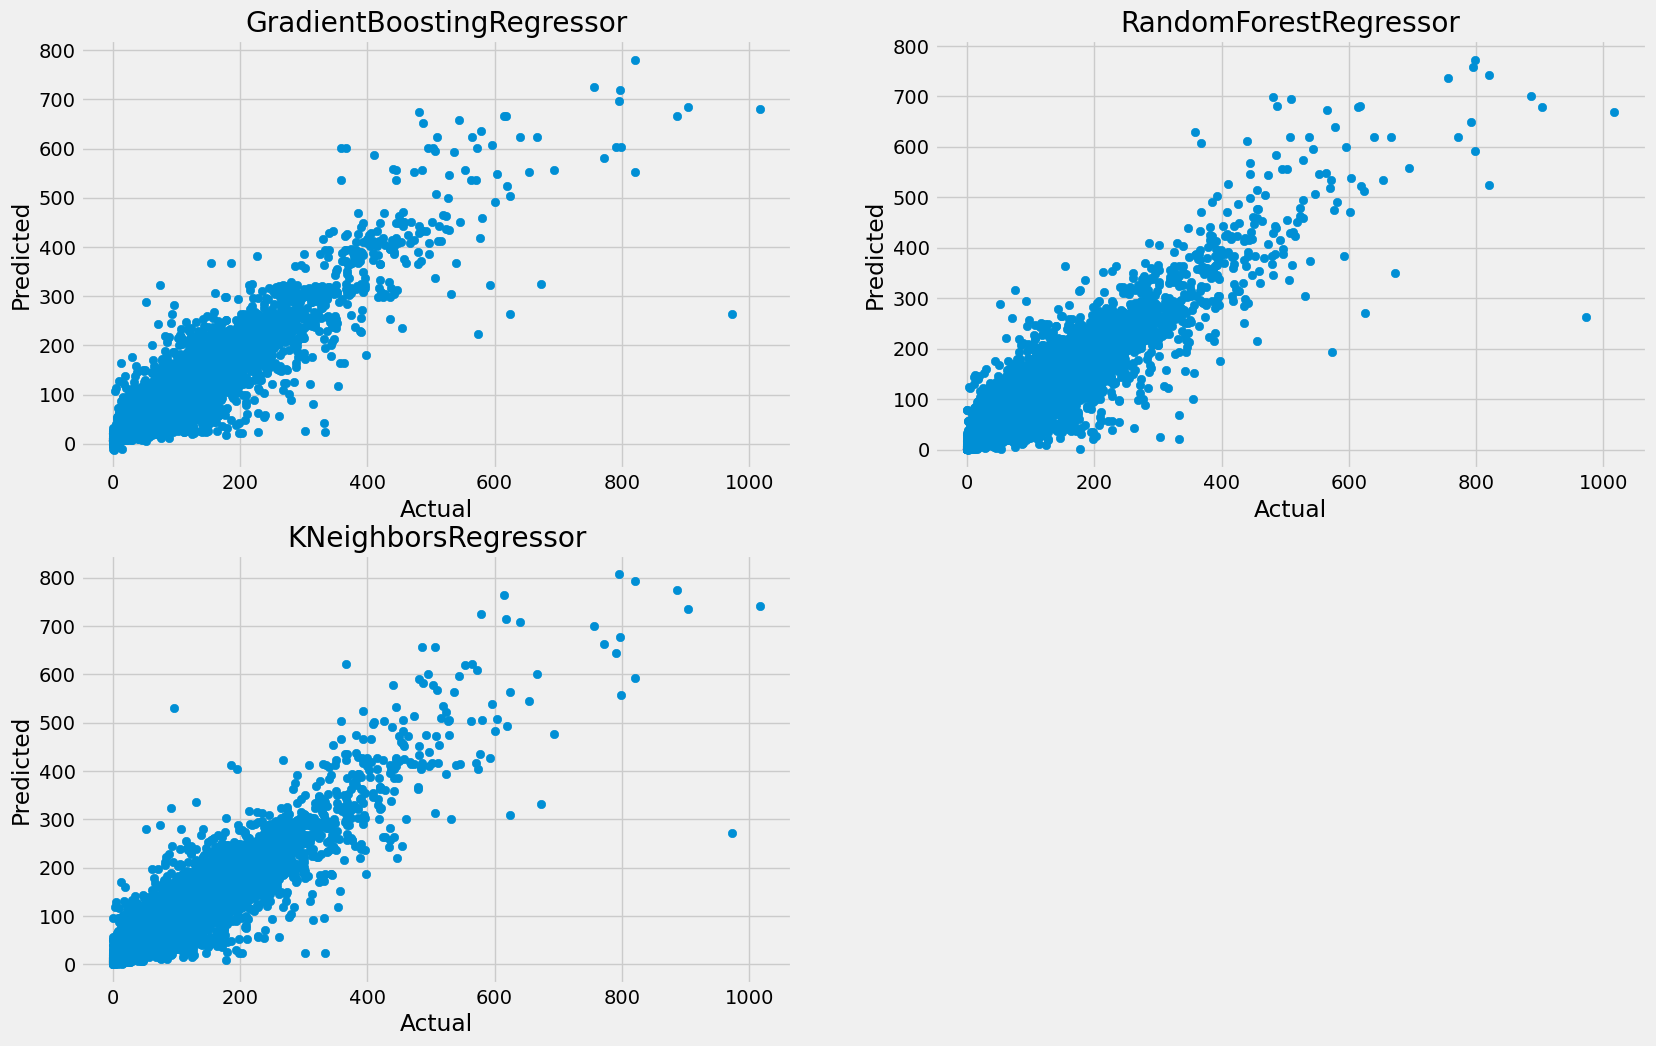

In [275]:
results = train_models(X_train, y_train, X_test, y_test)

In [276]:
results

,Model,MAE,MSE,RMSE,MAPE,R2 Score
0,GradientBoostingRegressor,10.353821,396.718352,19.917790,1.463916e+14,0.883532
1,RandomForestRegressor,11.305992,439.801044,20.971434,7.982763e+13,0.870884
2,KNeighborsRegressor,11.443170,437.821982,20.924196,1.616947e+14,0.871465


# hyperparameter optimization of all models using GridSearchCV

In [278]:

def train_models(X_train, y_train, X_test, y_test):
    results_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2 Score'])
    best_params = {}

    # Models and their parameter grids
    models = {
        
        'GradientBoostingRegressor': (GradientBoostingRegressor(random_state=1000), {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }),
        'RandomForestRegressor': (RandomForestRegressor(random_state=1000), {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 10, 20]
        }),
        'KNeighborsRegressor': (KNeighborsRegressor(), {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }),
        
    }

    for i, (name, (model, param_grid)) in enumerate(models.items()):
        print(f"Training and evaluating {name}...\n{'_'*40}")

        # GridSearchCV
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params[name] = grid_search.best_params_

        # Train the model with the best parameters
        best_model.fit(X_train, y_train)

        # Predictions
        test_pred = best_model.predict(X_test)
        train_pred = best_model.predict(X_train)

        # Evaluation
        print(f'Test set evaluation for {name}:\n{"_"*40}')
        print_evaluate(y_test, test_pred)
        print(f'Train set evaluation for {name}:\n{"_"*40}')
        print_evaluate(y_train, train_pred)
        results_df.loc[i] = [name, *evaluate(y_test, test_pred)]

    # Print best parameters for each model
    print('\nBest parameters for each model:')
    for name, params in best_params.items():
        print(f'{name}: {params}')

    # Plot results
    print('====================================')
    print('Test set results for all models')
    plt.figure(figsize=(18, 18))
    for i, (name, (model, _)) in enumerate(models.items()):
        plt.subplot(3, 2, i + 1)
        plt.scatter(y_test, best_model.predict(X_test))
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(name)
    plt.show()

    return results_df


Training and evaluating GradientBoostingRegressor...
________________________________________
Test set evaluation for GradientBoostingRegressor:
________________________________________
Mean Absolute Error 10.078652608682859
Mean Squarred Error 385.9376000086753
Root Mean Squarred Error 19.645294602236824
mean_absolute_percentage_error 109526093157573.28
R2 Score: 0.8866967508736622
Train set evaluation for GradientBoostingRegressor:
________________________________________
Mean Absolute Error 9.635146795753501
Mean Squarred Error 308.78104808415577
Root Mean Squarred Error 17.572166857964778
mean_absolute_percentage_error 94434170487085.84
R2 Score: 0.9117212052853608
Training and evaluating RandomForestRegressor...
________________________________________
Test set evaluation for RandomForestRegressor:
________________________________________
Mean Absolute Error 10.25772450071401
Mean Squarred Error 399.3303731232191
Root Mean Squarred Error 19.983252315957458
mean_absolute_percentage

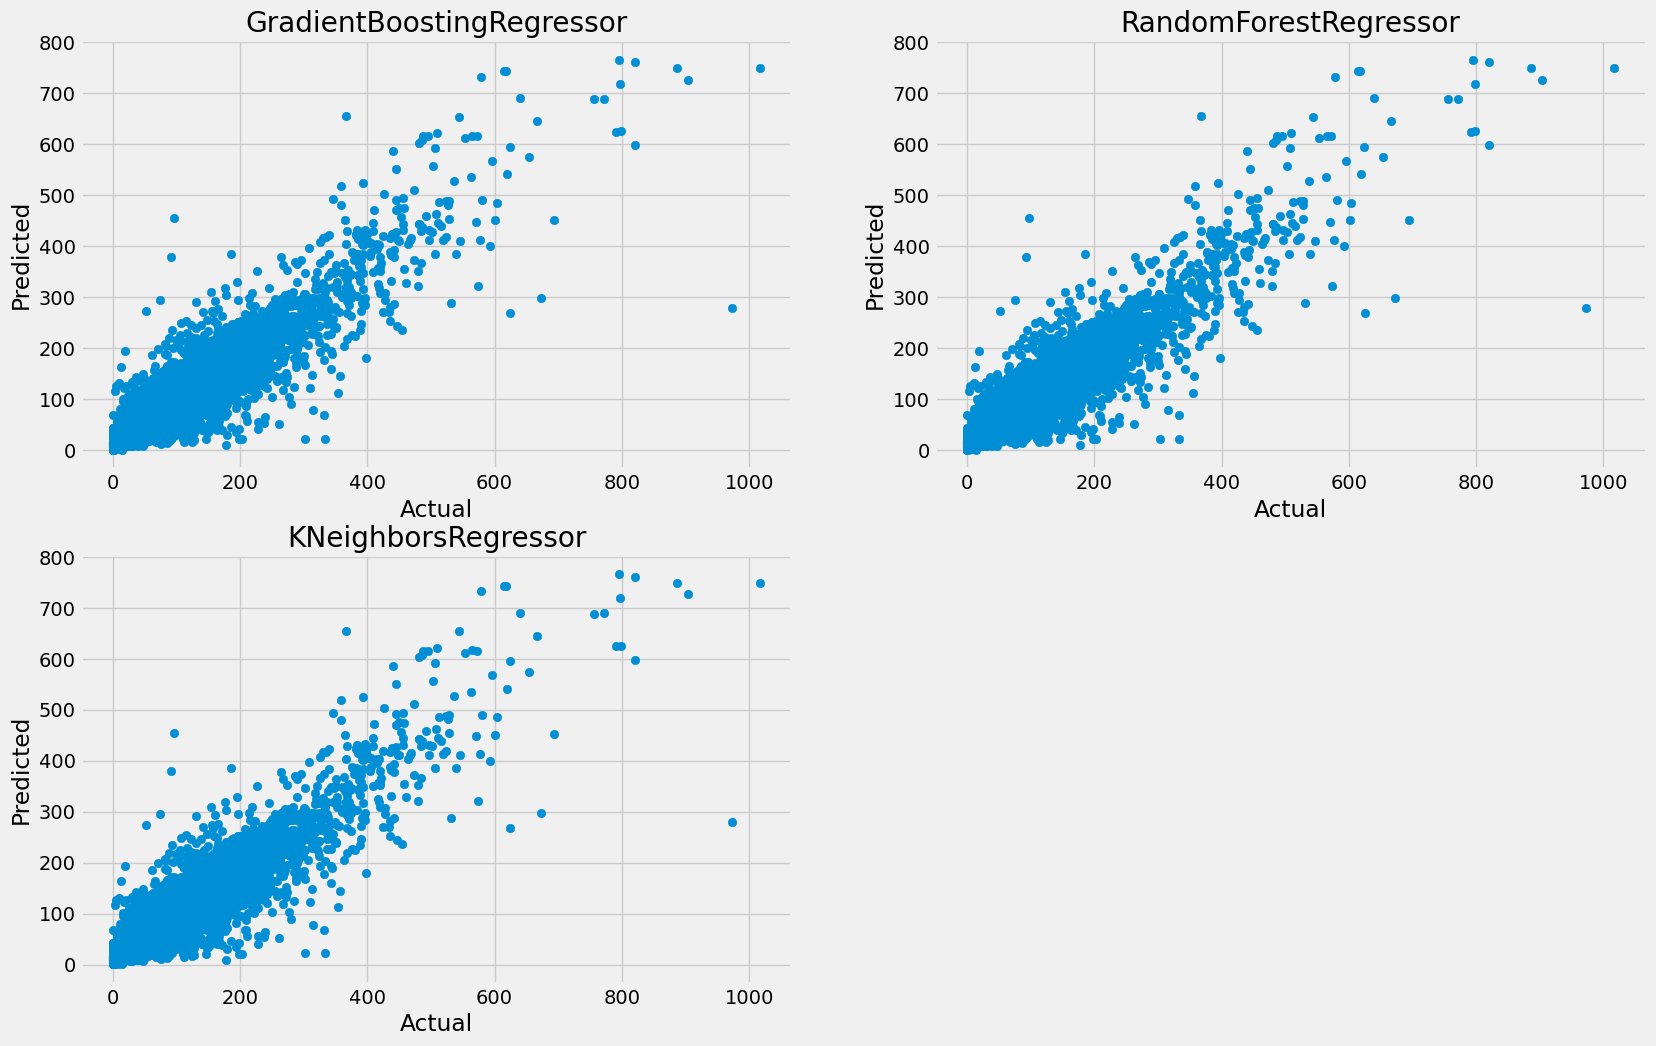

In [279]:
results = train_models(X_train, y_train, X_test, y_test)

In [280]:
results

,Model,MAE,MSE,RMSE,MAPE,R2 Score
0,GradientBoostingRegressor,10.078653,385.937600,19.645295,1.095261e+14,0.886697
1,RandomForestRegressor,10.257725,399.330373,19.983252,8.856654e+13,0.882765
2,KNeighborsRegressor,10.980848,418.805685,20.464742,1.797691e+14,0.877047
